# Explanation

My 3rd place result may have been a fluke. I am a mathematician by training (a topologist/geometer in particular), but I have recently been learning about data science because the university I teach at recently started a data science program. My background in biology/chemistry consists of high school courses 30 years ago. I found "Indaba Grand Challenge: Curing Leishmaniasis" because of a biology/math double-major advisee of mine. She really wanted to work on a math/data science project this summer and had already worked on a project about Leishmaniasis with a pharmacist at our university. I found the competition while searching for stuff like "data science, Leishmaniasis" on the internet and thought it looked interesting. 

I stopped working on actual submissions after I kept getting submission errors, so it has been a while since I looked at this code. To be honest, I cannot find the particular code that lead to my best submissions but I will explain what I did. It was a very naive approach and I actually misunderstood what data I was using in the beginning. I started by downloading the notebooks at https://gitlab.com/instadeep-public/grandchallenge. I did not realize at the time that the notebook "Bootstrap notebook" was not about _Leishmania_, but about _Trypanosoma_ (or rather that the two were different). I copied the "Bootstrap notebook" and thought I was training models to predict a compound's potency in regards to an enzyme in Leishmania. I trained models to predict potency using the data from ChEMBL and then made predictions on the provided compounds. I submitted the top few candidates. I stopped working on actual submissions when I kept getting errors, so my models were pretty basic. I started with the models in the notebook I downloaded (RandomForestRegressor, MLPRegressor, SVR) and then used LGBMRegressor from LightGBM. I did not tune it much, but my top submissions came from using LGBMRegressor as my predictor. I could not get pyrosetta installed on either my mac or my pc, so I used an online docker (https://mcule.com/apps/1-click-docking/) to generate the pdb files. That is where my submissions came from. I do now realize that _Trypanosoma_ and _Leishmania_ are different and have been learning background material and looking at recent papers to see what approaches people are using.

This notebook is not my best work. I do not have much coding experience and I am too busy right now to invest much time into editing it. I mean no disrespect by submitting a notebook that needs some editing, but I wanted to give you some sort of explanation about where my submissions came from. I appreciate the introduction to this field (especially the data).

In [1]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV

In [2]:
import numpy as np
import pandas as pd

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import Image
from rdkit.Chem import Descriptors

In [4]:
import lightgbm as lgb

# Training data

In [5]:
df = pd.read_csv('CHEMBL26-molecules.csv', sep=';')
df = df.dropna(subset=['Smiles', 'Molecule ChEMBL ID']).drop_duplicates(subset=['Molecule ChEMBL ID'])

In [6]:
df.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL1399166,NaN,0,382.17,0,1.60,SID24788739,Cc1c(Br)c([N+](=O)[O-])nn1CC(=O)Nc1ccc(C(N)=O)cc1,Potency,NaN,...,6-phospho-1-fructokinase,Trypanosoma brucei,SINGLE PROTEIN,CHEMBL1201862,7,PubChem BioAssays,NaN,NaN,None,NaN
1,CHEMBL1445913,NaN,0,244.09,0,0.85,SID26664850,NNC(=O)CNc1cccc(Br)c1,Potency,NaN,...,6-phospho-1-fructokinase,Trypanosoma brucei,SINGLE PROTEIN,CHEMBL1201862,7,PubChem BioAssays,NaN,NaN,None,NaN
2,CHEMBL1340503,NaN,0,260.15,0,3.46,SID17402158,Clc1cccc(NCc2nnsc2Cl)c1,Potency,NaN,...,6-phospho-1-fructokinase,Trypanosoma brucei,SINGLE PROTEIN,CHEMBL1201862,7,PubChem BioAssays,NaN,NaN,None,NaN
3,CHEMBL1401951,NaN,0,301.26,0,1.24,SID24822998,CN1C(=O)NC(=O)/C(=C\C=C\c2ccccc2[N+](=O)[O-])C1=O,Potency,NaN,...,6-phospho-1-fructokinase,Trypanosoma brucei,SINGLE PROTEIN,CHEMBL1201862,7,PubChem BioAssays,NaN,NaN,None,NaN
4,CHEMBL1413298,NaN,0,437.31,0,3.77,SID49680392,O=C(Cc1ccc(Cl)c(Cl)c1)Nc1ccc(S(=O)(=O)Nc2ncccn...,Potency,NaN,...,6-phospho-1-fructokinase,Trypanosoma brucei,SINGLE PROTEIN,CHEMBL1201862,7,PubChem BioAssays,NaN,NaN,None,NaN


In [7]:
df.shape

(5901, 45)

# Other data

In [8]:
drug_Central = pd.read_csv('drugCentral.csv').drop(columns=['Unnamed: 0'])
print(drug_Central.shape)
drug_Central.head()

(4052, 6)


,SMILES,InChI,InChIKey,ID,INN,CAS_RN
0,CCCCN1CCCC[C@H]1C(=O)NC1=C(C)C=CC=C1C,InChI=1S/C18H28N2O/c1-4-5-12-20-13-7-6-11-16(2...,LEBVLXFERQHONN-INIZCTEOSA-N,4,levobupivacaine,27262-47-1
1,COC(=O)C1=C(C)NC(C)=C([C@H]1C1=CC(=CC=C1)[N+](...,InChI=1S/C26H29N3O6/c1-17-22(25(30)34-4)24(20-...,ZBBHBTPTTSWHBA-DEOSSOPVSA-N,5,(S)-nicardipine,76093-36-2
2,CCOC(=O)C1=C(C)NC(C)=C([C@@H]1C1=CC(=CC=C1)[N+...,InChI=1S/C18H20N2O6/c1-5-26-18(22)15-11(3)19-1...,PVHUJELLJLJGLN-INIZCTEOSA-N,6,(S)-nitrendipine,80873-62-7
3,C[C@@H](CCC1=CC=C(O)C=C1)NCCC1=CC=C(O)C(O)=C1,InChI=1S/C18H23NO3/c1-13(2-3-14-4-7-16(20)8-5-...,JRWZLRBJNMZMFE-ZDUSSCGKSA-N,13,levdobutamine,61661-06-1
4,NC1=NC2=NC=C(CNC3=CC=C(C=C3)C(=O)N[C@@H](CCC(O...,InChI=1S/C19H20N8O5/c20-15-14-16(27-19(21)26-1...,TVZGACDUOSZQKY-LBPRGKRZSA-N,21,aminopterin,54-62-6


In [9]:
world = pd.read_csv('world.csv')
world.columns = ['zinc_id', 'Smiles']
print(world.shape)
world

(5903, 2)


,zinc_id,Smiles
0,ZINC000001532673,N[C@@H](CSSC[C@H](N)C(=O)O)C(=O)O
1,ZINC000001408068,O=C(O)c1cc(O)nc(O)n1
2,ZINC000001532582,NC(=O)CCCC[C@H]1CCSS1
3,ZINC000003830381,CCCCC[C@](C)(O)/C=C/[C@H]1[C@H](O)C[C@H](O)[C@...
4,ZINC000003830394,Cn1nnnc1SCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H...
...,...,...
5898,ZINC000101144764,C[N+]1(C)[C@@H]2C[C@H](OC(=O)C(O)(c3cccs3)c3cc...
5899,ZINC000118913164,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=C(CCC(=O)C4)[C@...
5900,ZINC000085537078,CC[C@]12C=CCN3CC[C@@]4(c5cc([C@@]6(C(=O)OC)C[C...
5901,ZINC000085537089,CCCN(CCC)C(=O)[C@@H](CCC(=O)OCCCN1CCN(CCOC(=O)...


In [10]:
endo = pd.read_csv('endogenous.csv')
endo.columns = ['zinc_id', 'Smiles']
print(endo.shape)
endo

(81519, 2)


,zinc_id,Smiles
0,ZINC000000119675,COc1cc(CCN)ccc1O
1,ZINC000000120430,COc1cccc(C(=O)O)c1
2,ZINC000003171672,CC1(C)C[C@H]2C(=O)CC[C@@H]3O[C@]3(C)CC[C@@H]21
3,ZINC000001572037,CC(C)[C@@H](NC(=O)[C@H](N)CCCCN)C(=O)O
4,ZINC000000895535,O=C(O)[C@H](O)Cc1ccc(O)c(O)c1
...,...,...
81514,ZINC000003869580,CN1C(=O)[C@@H](O)C[C@H]1c1cccnc1
81515,ZINC000004096817,C[C@]12CC[C@@H]3c4ccc(O[C@@H]5O[C@H](C(=O)O)[C...
81516,ZINC000021981408,CNC[C@@H](c1ccc(OC)cc1)C1(O)CCCCC1
81517,ZINC000022055143,CN1C(=O)CC[C@H]1c1ccc[n+]([C@H]2O[C@H](C(=O)O)...


In [11]:
all_data = pd.concat([drug_Central['SMILES'], world['Smiles'], endo['Smiles']]).reset_index()
all_data.columns = ['old_index','Smiles']

In [12]:
all_data

,old_index,Smiles
0,0,CCCCN1CCCC[C@H]1C(=O)NC1=C(C)C=CC=C1C
1,1,COC(=O)C1=C(C)NC(C)=C([C@H]1C1=CC(=CC=C1)[N+](...
2,2,CCOC(=O)C1=C(C)NC(C)=C([C@@H]1C1=CC(=CC=C1)[N+...
3,3,C[C@@H](CCC1=CC=C(O)C=C1)NCCC1=CC=C(O)C(O)=C1
4,4,NC1=NC2=NC=C(CNC3=CC=C(C=C3)C(=O)N[C@@H](CCC(O...
...,...,...
91469,81514,CN1C(=O)[C@@H](O)C[C@H]1c1cccnc1
91470,81515,C[C@]12CC[C@@H]3c4ccc(O[C@@H]5O[C@H](C(=O)O)[C...
91471,81516,CNC[C@@H](c1ccc(OC)cc1)C1(O)CCCCC1
91472,81517,CN1C(=O)CC[C@H]1c1ccc[n+]([C@H]2O[C@H](C(=O)O)...


In [13]:
df.iloc[0]

Molecule ChEMBL ID                                                CHEMBL1399166
Molecule Name                                                               NaN
Molecule Max Phase                                                            0
Molecular Weight                                                         382.17
#RO5 Violations                                                               0
AlogP                                                                      1.60
Compound Key                                                        SID24788739
Smiles                        Cc1c(Br)c([N+](=O)[O-])nn1CC(=O)Nc1ccc(C(N)=O)cc1
Standard Type                                                           Potency
Standard Relation                                                           NaN
Standard Value                                                          13459.1
Standard Units                                                               nM
pChEMBL Value                           

In [14]:
# input = dataframe with 'Smiles' column
def add_descriptors(df): 
    
    df['mol'] = df['Smiles'].apply(Chem.MolFromSmiles)
    df['MolLogP'] = df['mol'].apply(Descriptors.MolLogP)
    df['AMW'] = df['mol'].apply(Descriptors.MolWt)
    df['NumRotatableBonds'] = df['mol'].apply(Descriptors.NumRotatableBonds)
    df['fp']=df['mol'].apply(AllChem.GetMorganFingerprintAsBitVect, args=(2, 2048))
    
    df = df.dropna(subset=['mol'])
    df['HeavyAtomCount'] = df['mol'].apply(Descriptors.HeavyAtomCount)
    df['HAccept'] = df['mol'].apply(Descriptors.NumHAcceptors)
    df['HDonor'] = df['mol'].apply(Descriptors.NumHDonors)
    df['Heteroatoms'] = df['mol'].apply(Descriptors.NumHeteroatoms)
    df['RingCount'] = df['mol'].apply(Descriptors.RingCount)
    df['SaturatedRings'] = df['mol'].apply(Descriptors.NumSaturatedRings)
    df['AliphaticRings'] = df['mol'].apply(Descriptors.NumAliphaticRings)
    df['AromaticRings'] = df['mol'].apply(Descriptors.NumAromaticRings)
    df['Ipc'] = df['mol'].apply(Descriptors.Ipc)
    df['HallKierAlpha'] = df['mol'].apply(Descriptors.HallKierAlpha)
    df['NumValenceElectrons'] = df['mol'].apply(Descriptors.NumValenceElectrons)
    
    df["ECFP6"] = df['mol'].apply(AllChem.GetMorganFingerprintAsBitVect, args=(3, 2048))
    df["RDKFP"] = df['mol'].apply(AllChem.RDKFingerprint, fpSize=2048)
    
    return(df)

In [15]:
features1 = ['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons']

features2 = ['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons','ECFP6','RDKFP']

In [16]:
df = add_descriptors(df)

In [17]:
df['logValue'] = np.log(df['Standard Value'])

/Users/bres4224/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='logValue', ylabel='Density'>

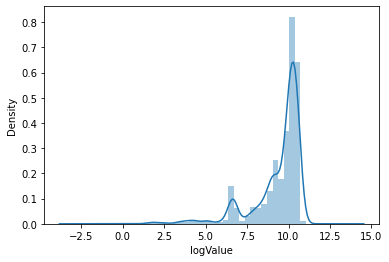

In [18]:
sns.distplot(df['logValue'])

In [27]:
all_data = add_descriptors(all_data)

RDKit WARNING: [08:49:34] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [08:49:34]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [08:49:35] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [08:49:35]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [28]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [29]:
df = df.loc[(df['Standard Type'] == 'Potency') & (df['Standard Units'] == 'nM')].dropna(subset=['Standard Value'])
df['logValue'] = 1 * np.log(df['Standard Value'])
X = df[features1]
y = df['logValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

# Default models
models = {"rf": RandomForestRegressor(n_estimators=100, random_state=42)}

scores = {}
for m in models:
    models[m].fit(X_train, y_train)
    scores[m + "_train"] = models[m].score(X_train, y_train, )
    y_pred = models[m].predict(X_test)
    scores[m + "_test"] = r2_score(y_test, y_pred)
    scores[m + "_rmse_test"] = np.sqrt(mean_squared_error(y_test, y_pred))
    

scores = pd.Series(scores).T
scores

rf_train        0.849127
rf_test        -0.032369
rf_rmse_test    1.527600
dtype: float64

In [30]:
df = df.loc[(df['Standard Type'] == 'Potency') & (df['Standard Units'] == 'nM')].dropna(subset=['Standard Value'])
df['logValue'] = 1 * np.log(df['Standard Value'])
X = df[features1]
y = df['logValue']

scaler = StandardScaler()
#X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [31]:
# Default models
models = {"rf": RandomForestRegressor(n_estimators=100, random_state=42)}

scores = {}
for m in models:
    models[m].fit(X_train, y_train)
    scores[m + "_train"] = models[m].score(X_train, y_train, )
    y_pred = models[m].predict(X_test)
    scores[m + "_test"] = r2_score(y_test, y_pred)
    scores[m + "_rmse_test"] = np.sqrt(mean_squared_error(y_test, y_pred))
    

scores = pd.Series(scores).T
scores

rf_train        0.849127
rf_test        -0.032369
rf_rmse_test    1.527600
dtype: float64

In [32]:
# It takes some time, so for the sake of demonstration I will subsample the dataset
df = df.sample(frac=0.4)
y = -1*df['logValue']

models = {"rf": RandomForestRegressor(n_estimators=100, random_state=1337),
          "nnet": MLPRegressor(random_state=1337),
          "svr": SVR(gamma='auto')}
scores = {}

for f in ['fp', 'ECFP6', 'RDKFP']:
    print('Working on ', f, '...')
    scores[f] = {}
    # Convert fps to 2D numpy array
    X = np.array(df[f].tolist())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    for k, m in enumerate(models):
        models[m].fit(X_train, y_train)
        y_pred = models[m].predict(X_test)
        #preds = models[m].predict(all_data[f].tolist())
        scores[f][m + "_r2_test"] = r2_score(y_test, y_pred)
        scores[f][m + "_rmse_test"] = np.sqrt(mean_squared_error(y_test, y_pred))

Working on  fp ...


/Users/bres4224/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Working on  ECFP6 ...


/Users/bres4224/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Working on  RDKFP ...


/Users/bres4224/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [33]:
scores

{'fp': {'rf_r2_test': -0.09486513380110395,
  'rf_rmse_test': 1.509962844293998,
  'nnet_r2_test': -1.8980900149548878,
  'nnet_rmse_test': 2.4566420600782046,
  'svr_r2_test': -0.20444644241183751,
  'svr_rmse_test': 1.5837247157791943},
 'ECFP6': {'rf_r2_test': -0.05542877562669424,
  'rf_rmse_test': 1.4825194957179917,
  'nnet_r2_test': -2.73732111354368,
  'nnet_rmse_test': 2.78975558061453,
  'svr_r2_test': -0.21140462746567645,
  'svr_rmse_test': 1.5882927810019365},
 'RDKFP': {'rf_r2_test': -0.044135242884131065,
  'rf_rmse_test': 1.4745663713224786,
  'nnet_r2_test': -1.2149367668921878,
  'nnet_rmse_test': 2.147665367782273,
  'svr_r2_test': -0.15522750576166655,
  'svr_rmse_test': 1.5510282508393252}}

# LightGBM

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

In [35]:
SEED = 2021
params = {
              'boosting_type': 'gbdt',
              'n_estimators': 1000,
              'learning_rate': 0.1,
              'num_leaves': 10,
              'colsample_bytree': 0.6, #0.4
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': SEED,
              'reg_alpha': 8,
              'reg_lambda': 2,
              'random_state': SEED,
              'n_jobs': -1,
              'min_child_samples' : 25,
              'metric' : 'mse',
              }

In [36]:
# Default models
models = {"lgb": lgb.LGBMRegressor(**params)}

scores = {}
for m in models:
    models[m].fit(X_train, y_train)
    scores[m + "_train"] = models[m].score(X_train, y_train )
    y_pred = models[m].predict(X_test)
    scores[m + "_test"] = r2_score(y_test, y_pred)
    scores[m + "_rmse_test"] = np.sqrt(mean_squared_error(y_test, y_pred))
    

scores = pd.Series(scores).T
scores

lgb_train        0.934150
lgb_test        -0.152908
lgb_rmse_test    1.496079
dtype: float64

In [37]:
df = df.reset_index(drop=True)

In [38]:
df = df.loc[(df['Standard Type'] == 'Potency') & (df['Standard Units'] == 'nM')].dropna(subset=['Standard Value'])
df['logValue'] = 1 * np.log(df['Standard Value'])
X = df[features1]
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=features1)
y = df['logValue']

In [39]:
df['Standard Value'].describe()

count     2319.000000
mean     20733.972445
std      12780.615457
min          2.100000
25%       8492.100000
50%      21331.300000
75%      30131.300000
max      60119.800000
Name: Standard Value, dtype: float64

In [40]:
kfold = KFold(5, True, 1)
fold = 1
fold_preds = []
scores = []
for train_index, test_index in kfold.split(df):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    model = lgb.LGBMRegressor(**params)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    print('Fold ', fold, ': ',score)
    
    preds = model.predict(all_data[features1])
    #print(preds.shape)
    fold_preds.append(preds)
    
    # save model
    #joblib.dump(model, 'lgb'+str(fold)+'.pkl')

    fold += 1

/Users/bres4224/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Fold  1 :  1.5708647677801395
Fold  2 :  1.4453558365434487
Fold  3 :  1.5573057731542606
Fold  4 :  1.5302964324309745
Fold  5 :  1.6376232886654885


In [41]:
all_preds = np.stack(fold_preds)

In [42]:
all_preds.shape

(5, 91474)

In [43]:
ave_preds = all_preds.sum(axis=0) / all_preds.shape[0]

In [44]:
ave_preds

array([8.34886008, 8.74912648, 8.98532726, ..., 7.81851572, 9.45770281,
       8.75107008])

In [45]:
model.fit(X,y)
big_preds = model.predict(all_data[features1])

/Users/bres4224/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

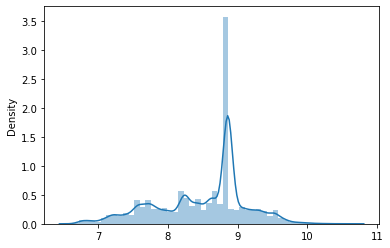

In [46]:
sns.distplot(preds)

/Users/bres4224/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

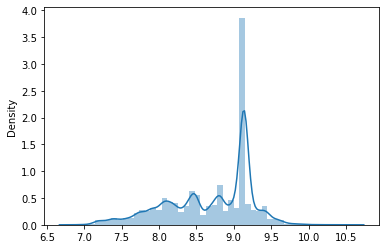

In [47]:
sns.distplot(ave_preds)

In [48]:
all_data['ave_pred'] = ave_preds

In [49]:
all_data['big_preds'] = big_preds

In [50]:
all_data.big_preds.describe()

count    91474.000000
mean         8.620774
std          0.600650
min          6.508980
25%          8.213579
50%          8.718417
75%          9.120038
max         10.819740
Name: big_preds, dtype: float64

In [51]:
all_data.ave_pred.describe()

count    91474.000000
mean         8.684867
std          0.572839
min          6.842873
25%          8.241590
50%          8.821378
75%          9.133824
max         10.562756
Name: ave_pred, dtype: float64

In [52]:
candidate = all_data.sort_values('ave_pred', ascending=False).iloc[1,1]
candidate

'C[C@H]1OC[C@@H](C)O1'

In [56]:
candidate2 = all_data.sort_values('big_preds', ascending=False).iloc[1,1]
candidate2

'C[C@H]1CO[C@H](C)O1'

In [67]:
candidate3 = all_data.sort_values('big_preds', ascending=False).iloc[6,1]
candidate3

'CC1=N[C@@H](C)OC1'

In [70]:
all_data.sort_values('big_preds', ascending=False)

,old_index,Smiles,mol,MolLogP,AMW,NumRotatableBonds,fp,HeavyAtomCount,HAccept,HDonor,...,SaturatedRings,AliphaticRings,AromaticRings,Ipc,HallKierAlpha,NumValenceElectrons,ECFP6,RDKFP,ave_pred,big_preds
47643,37688,C[C@H]1CO[C@@H](C)O1,<rdkit.Chem.rdchem.Mol object at 0x1e8410a00>,0.7677,102.133,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,2,0,...,1,1,0,46.670483,-0.08,42,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.562756,10.81974
53135,43180,C[C@H]1CO[C@H](C)O1,<rdkit.Chem.rdchem.Mol object at 0x1e8493640>,0.7677,102.133,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,2,0,...,1,1,0,46.670483,-0.08,42,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.562756,10.81974
25457,15502,C[C@@H]1CO[C@@H](C)O1,<rdkit.Chem.rdchem.Mol object at 0x1e8200760>,0.7677,102.133,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,2,0,...,1,1,0,46.670483,-0.08,42,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.562756,10.81974
48031,38076,C[C@H]1OC[C@@H](C)O1,<rdkit.Chem.rdchem.Mol object at 0x1e8419dc0>,0.7677,102.133,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,2,0,...,1,1,0,46.670483,-0.08,42,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.562756,10.81974
72101,62146,O=C1CCSC1,<rdkit.Chem.rdchem.Mol object at 0x1e8656a60>,0.6924,102.158,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,2,0,...,1,1,0,33.548875,0.02,34,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10.428995,10.70250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8923,4871,N[C@@H]1C[C@@H]1c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x1e8076ca0>,1.5012,133.194,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,1,1,...,1,1,1,495.271512,-0.82,52,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",6.922493,6.50898
2444,2444,N[C@@H]1C[C@H]1C1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x1e7fdc880>,1.5012,133.194,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,1,1,...,1,1,1,495.271512,-0.82,52,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",6.922493,6.50898
6446,2394,N[C@H]1C[C@@H]1c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x1e803bd00>,1.5012,133.194,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,1,1,...,1,1,1,495.271512,-0.82,52,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",6.922493,6.50898
6422,2370,N[C@@H]1C[C@H]1c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x1e803b400>,1.5012,133.194,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,1,1,...,1,1,1,495.271512,-0.82,52,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",6.922493,6.50898


In [55]:
# C(C1C(=CC(OC)=CC=1OC)OC)(=O)CCCN1CCCC1